In [1]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd
#plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#nltk
import nltk
from nltk.stem import WordNetLemmatizer
#sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
dataset_columns = ['tweet','brand','sentiment']
dataset_encoding = 'latin1'
dataset = pd.read_csv('../../../../../Downloads/judge-1377884607_tweet_product_company.csv', encoding = dataset_encoding, names=dataset_columns)

In [4]:
dataset.head()

,tweet,brand,sentiment
0,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_pro...
1,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
2,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
3,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion


In [5]:
dataset.describe

<bound method NDFrame.describe of                                                   tweet  \
0                                            tweet_text   
1     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
2     @jessedee Know about @fludapp ? Awesome iPad/i...   
3     @swonderlin Can not wait for #iPad 2 also. The...   
4     @sxsw I hope this year's festival isn't as cra...   
...                                                 ...   
9089                      Ipad everywhere. #SXSW {link}   
9090  Wave, buzz... RT @mention We interrupt your re...   
9091  Google's Zeiger, a physician never reported po...   
9092  Some Verizon iPhone customers complained their...   
9093  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                                brand  \
0     emotion_in_tweet_is_directed_at   
1                              iPhone   
2                  iPad or iPhone App   
3                                iPad   
4                  iPad or iPhone App   
...        

In [6]:
dataset.sentiment.value_counts()

No emotion toward brand or product                    5389
Positive emotion                                      2978
Negative emotion                                       570
I can't tell                                           156
is_there_an_emotion_directed_at_a_brand_or_product       1
Name: sentiment, dtype: int64

In [20]:
postive = dataset.loc[dataset['sentiment'] == 'Positive emotion']
negative = dataset.loc[dataset['sentiment'] == 'Negative emotion']
dataset = pd.concat([postive,negative])

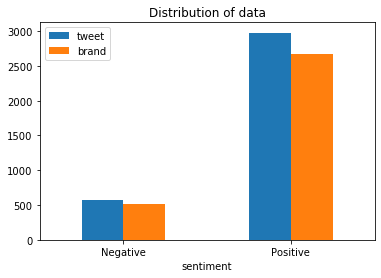

In [22]:
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['tweet']), list(dataset['sentiment'])

In [23]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


In [29]:
text

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB',
 'Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear',
 'Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail',
 "Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.",
 'Foursqu

In [24]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [25]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 5 seconds


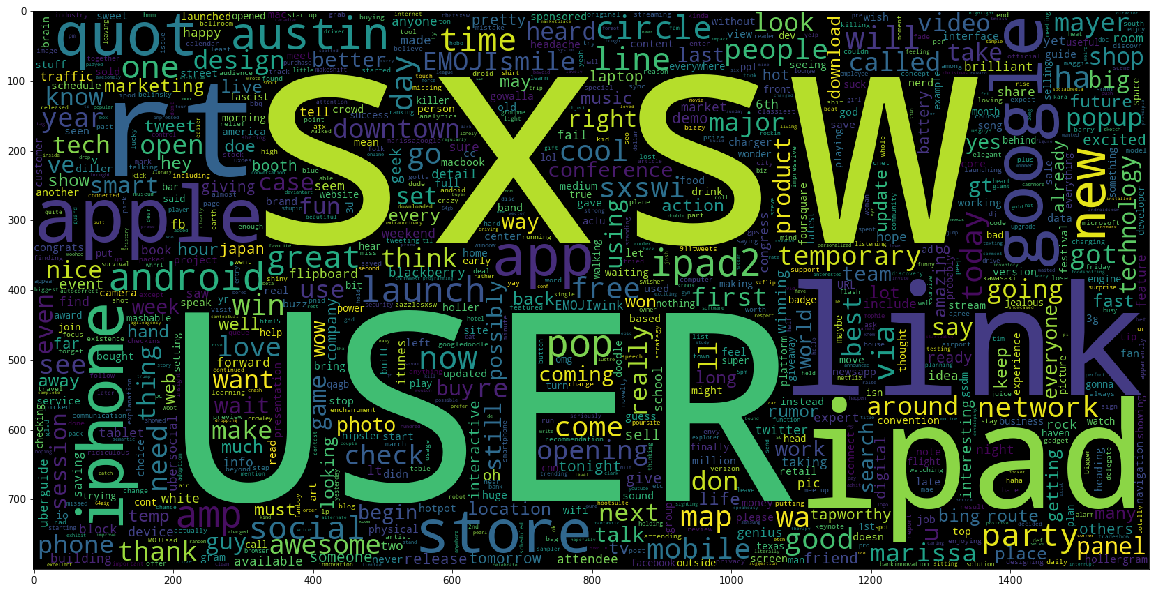

In [28]:
data_neg = processedtext
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [32]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  10000


In [33]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [34]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

                  precision    recall  f1-score   support

Negative emotion       1.00      0.06      0.11       115
Positive emotion       0.85      1.00      0.92       595

        accuracy                           0.85       710
       macro avg       0.92      0.53      0.52       710
    weighted avg       0.87      0.85      0.79       710



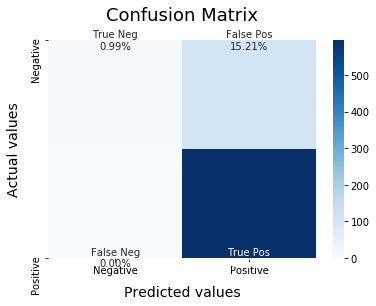

In [35]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)